In [1]:
import pandas as pd
%matplotlib inline
from scipy.misc import imread
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.utils import resample
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

xray_dir = '/home/dattran/data/xray/'
# https://elitedatascience.com/imbalanced-classes
# https://github.com/dattran2346/2015lab5/blob/master/Classification.ipynb

#### Take a look at the data

In [2]:
df = pd.read_csv('xray.csv')
df.head()

,patient_id,image,pneumonia,follow_up,patient_age,patient_gender,view_position
0,2,00000002_000.png,False,0,81,M,PA
1,5,00000005_000.png,False,0,69,F,PA
2,5,00000005_001.png,False,1,69,F,AP
3,5,00000005_002.png,False,2,69,F,AP
4,5,00000005_003.png,False,3,69,F,PA


#### Utility function

In [3]:
## Let display some image 
def plot_sample_xray(pneumonia=True, n=3):
    image_files = df[df.pneumonia == pneumonia].sample(n=n)
    print(image_files)
    image_files = xray_dir + image_files.image.values
    for file in image_files:
        print(file)
        image = cv2.imread(file)
        print(image.shape)
        plt.figure()
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

In [4]:
def performance_on_test(clf, Xtest, ytest):
    ypred = clf.predict(Xtest)
    print('Overal')
    print(classification_report(ytest, ypred))
    print('\tPredicted')
    print('Observed  0\t1')
    matrix = confusion_matrix(ytest, ypred)
    print('\t0', matrix[0])
    print('\t1', matrix[1])
    print('Accuracy', clf.score(Xtest, ytest))

### Let's plot some normal xray

       patient_id             image  pneumonia  follow_up  patient_age  \
115            68  00000068_000.png      False          0           65   
1910          940  00000940_000.png      False          0           47   
14482        6400  00006400_000.png      False          0           25   

      patient_gender view_position  
115                F            PA  
1910               M            PA  
14482              F            PA  
/home/dattran/data/xray/00000068_000.png
(1024, 1024, 3)
/home/dattran/data/xray/00000940_000.png
(1024, 1024, 3)
/home/dattran/data/xray/00006400_000.png
(1024, 1024, 3)


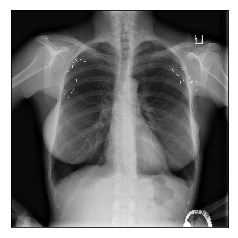

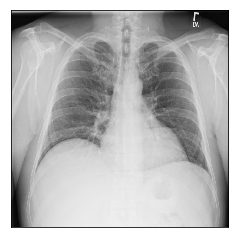

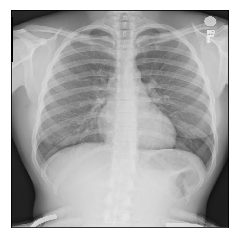

In [21]:
plot_sample_xray(pneumonia=False)

       patient_id             image  pneumonia  follow_up  patient_age  \
6032         2673  00002673_001.png       True          1           19   
60379       29801  00029801_002.png       True          2           24   
36685       15806  00015806_003.png       True          3           37   

      patient_gender view_position  
6032               M            PA  
60379              F            AP  
36685              M            AP  
/home/dattran/data/xray/00002673_001.png
(1024, 1024, 3)
/home/dattran/data/xray/00029801_002.png
(1024, 1024, 3)
/home/dattran/data/xray/00015806_003.png
(1024, 1024, 3)


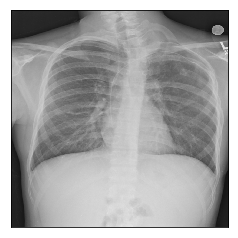

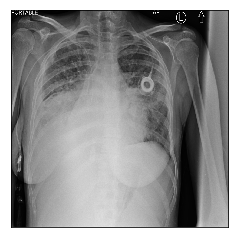

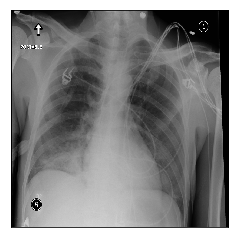

In [22]:
### Now plot some pneumonia image
plot_sample_xray(pneumonia=True)

In [5]:
### Get all the pneumonia sample
df_pneumonia = df[df.pneumonia == True]
df_normal = df[df.pneumonia == False]
print('Pneumoia patient in dataset:', df_pneumonia.shape)
print('Normal patient in dataset:', df_normal.shape)

Pneumoia patient in dataset: (1353, 7)
Normal patient in dataset: (60410, 7)


Plainly predict all the image to be normal will yield the accuracy of 99.77%, that the baseline we have to beat :)))

### Balance the dataset first

In [7]:
# for simplicity, consider only a small subset of images, about ~500 images for each label
n_images = 200 # change n to larger number when ready
n_normal = int(n_images * (1 + np.random.uniform(-0.2, 0.2)))
n_pneumonia = int(n_images * (1 + np.random.uniform(-0.2, 0.2)))
print(n_normal, n_pneumonia)

195 209


In [11]:
df_pneumonia_small = df_pneumonia.sample(n=n_pneumonia)
df_normal_small = df_normal.sample(n=n_normal)
df_small = pd.concat([df_normal_small, df_pneumonia_small])
images = [cv2.imread(xray_dir + file).reshape(-1, 1).squeeze() for file in df_small.image.values]
print(images[0].shape)

(3145728,)


### Trying PCA to extract feature form the image

In [12]:
from sklearn.decomposition import PCA
n_components = 60 # change this number
pca = PCA(n_components=n_components)
X = pca.fit_transform(images)

In [13]:
print('60 pc explained:', pca.explained_variance_ratio_.sum())
print(X.shape)
print(pca.components_.shape)

60 pc explained: 0.9111096330796045
(404, 60)
(60, 3145728)


In [14]:
print(pca.explained_variance_ratio_*100)
print(pca.explained_variance_ratio_.shape)

[28.4991377   9.12915131  7.50553528  6.47368274  5.62601759  4.45637912
  3.20535075  2.11700265  1.9342656   1.63245731  1.53122385  1.33786251
  1.15757491  1.04682416  0.94700305  0.92520651  0.84327536  0.78244432
  0.75635333  0.70593546  0.64039302  0.56991796  0.51307592  0.50157842
  0.46463939  0.43516612  0.42495103  0.40652686  0.39260134  0.36131295
  0.33582948  0.32807111  0.31343972  0.28066864  0.26510642  0.25318594
  0.23797144  0.22882959  0.22696952  0.21913392  0.21100557  0.20815767
  0.19733756  0.18222175  0.17744006  0.17286656  0.16738636  0.16449323
  0.15986001  0.1545004   0.1496478   0.14238464  0.14044579  0.13631002
  0.13069817  0.12758787  0.12358733  0.12151845  0.11773686  0.11372489]
(60,)


In [15]:
df_pca = pd.DataFrame({'y': df_small.pneumonia})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df_pca['pc%i' % (i+1)] = X[:, i]
df_pca.head()

,y,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
8042,False,48599.987480,-43150.918949,11113.914300,57661.490602,-16476.213030,-53887.964187,42437.317114,13721.996931,2781.982828,...,-5515.736644,7907.981653,1283.749224,-5644.798819,-6232.694955,6441.742650,-3794.996268,-5327.581520,2863.483830,5042.873910
3838,False,-49476.672445,-3234.525497,3851.436986,-7004.618978,-897.317709,-19919.384574,6505.855479,1180.455303,-8796.246251,...,1736.133223,-5236.061448,2263.903012,619.928553,837.931920,1038.002332,-2333.964696,3217.653526,1198.822942,-3447.842316
17167,False,-62001.614069,1525.012839,-18567.297789,11626.901658,23215.693898,-17454.854511,-4055.228156,-24543.083376,-4673.953671,...,5106.889153,-3032.762649,-1856.911122,-4834.152322,-4643.032494,-3728.003066,-2102.047756,-358.779331,121.091081,-1077.556248
38397,False,-92746.649122,-3545.749660,-3361.311599,-14787.363275,-12716.113071,24484.255332,13867.545964,-1039.465993,216.831404,...,-857.593466,-8238.867916,1144.723499,-3982.827189,3162.985341,2030.722896,-2030.350770,-5011.815034,-693.640351,1392.052365
5049,False,-54253.133380,-32604.426520,15215.112355,372.170453,-27499.768232,-18689.448368,-16869.082131,-1306.849860,-4106.619823,...,1234.194631,-731.193689,-5946.173986,2691.918474,738.415729,-2525.820211,-328.306006,-3100.144704,1321.673375,2529.065063


#### Let's visualize PCA
eigenfaces of xray

In [16]:
def normit(a):
    a = (a - a.min()) / (a.max() - a.min())
    a = a * 256
    return np.round(a)

def getNC(pc, j):
    size = 1024 * 1024 * 3
    r = pc.components_[j][0:size:3]
    g = pc.components_[j][1:size:3]
    b = pc.components_[j][2:size:3]
    r = normit(r)
    g = normit(g)
    b = normit(b)
    return r, g, b

def display_component(pc, j):
    r, g, b = getNC(pc, j)
    rgbArray = np.empty((1024, 1024, 3), 'uint8')
    rgbArray[..., 0] = r.reshape(1024, 1024)
    rgbArray[..., 1] = g.reshape(1024, 1024)
    rgbArray[..., 2] = b.reshape(1024, 1024)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

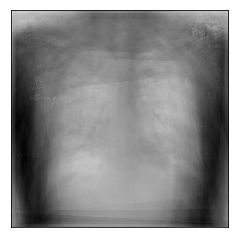

In [59]:
display_component(pca, 0)

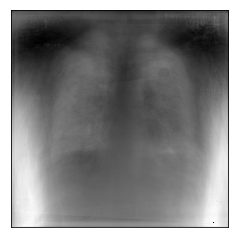

In [60]:
display_component(pca, 1)

Text(0,0.5,'pc2')

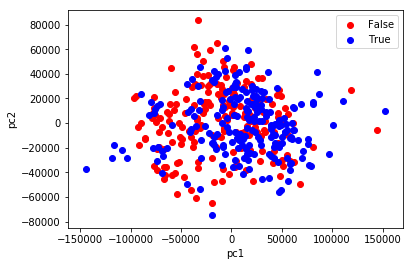

In [17]:
colors = ['r', 'b']
for label, color in zip(df_small.pneumonia.unique(), colors):
    mask = df_small.pneumonia == label
    plt.scatter(df_pca[mask].pc1, df_pca[mask].pc2, c=color, label=label)
plt.legend()
plt.xlabel('pc1')
plt.ylabel('pc2')

Look like no hope for Linear classifier

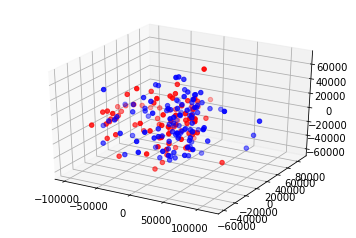

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for label, color in zip(df_small.pneumonia.unique(), colors):
    mask = df_small.pneumonia == label
    ax.scatter(df_pca[mask].pc1, df_pca[mask].pc2, df_pca[mask].pc3, color=color, label=label)


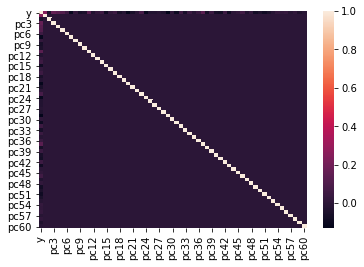

In [18]:
sns.heatmap(df_pca.corr())

#### Classification on reduce feature space

In [19]:
X = df_pca.drop('y', axis=1)
y = df_pca.y
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.8, random_state=1)

/home/dattran/miniconda2/envs/dat/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Algos 1: SVM 
http://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py

PCA reduce the dimension, hence help to reduce the Curse of Dimensionality. However, SVM do the classifying using the kernel trick to increase the feature dimension. Isn't it nonsense?

In [20]:
from sklearn.svm import SVC
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
               'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
svm_clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
svm_clf.fit(Xtrain, ytrain)
print('Best svm clf', svm_clf.best_estimator_)

Best svm clf SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [21]:
performance_on_test(svm_clf, Xtest, ytest)

Overal
             precision    recall  f1-score   support

      False       0.00      0.00      0.00        36
       True       0.56      1.00      0.71        45

avg / total       0.31      0.56      0.40        81

	Predicted
Observed  0	1
	0 [ 0 36]
	1 [ 0 45]
Accuracy 0.5555555555555556


/home/dattran/miniconda2/envs/dat/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Look like no hope for SVM